train.csv shape is  (87565, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays with 

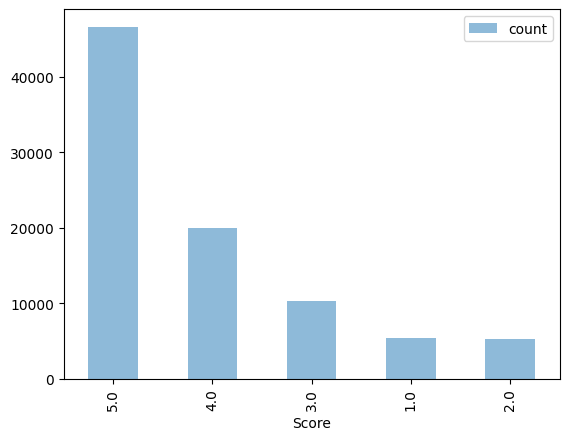


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


<ipython-input-1-6442698b6a53>:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_submission.fillna(0, inplace=True)


Accuracy on testing set =  0.5510688836104513


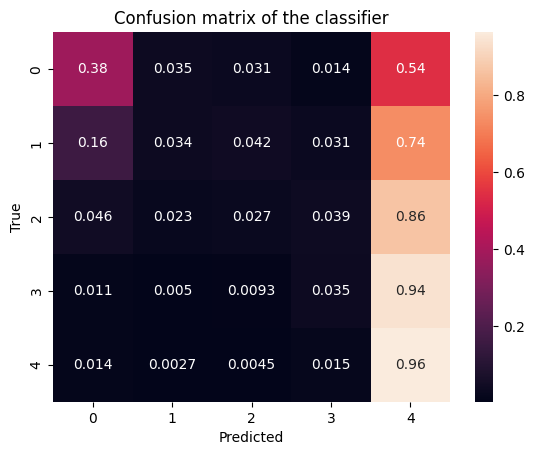

In [1]:
# Libraries
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Loading the Files
trainingSet = pd.read_csv("/content/train.csv", engine='python', on_bad_lines='skip')
testingSet = pd.read_csv("/content/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features (Updated)
def add_features_to_optimized(df):
    # Helpfulness as before
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # New features
    # Review length
    df['ReviewLength'] = df['Text'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

    return df

# Load the feature extracted files if they've already been generated
if exists('/content/X_train.csv'):
    X_train = pd.read_csv("/content/X_train.csv")
    X_submission = pd.read_csv("/content/X_submission.csv")

else:
    # Process the DataFrame with optimized features
    train_optimized = add_features_to_optimized(trainingSet)

    # The training set is where the score is not null
    X_train = train_optimized[train_optimized['Score'].notnull()]

    # Merge the testing set with the processed train features using 'Id'
    X_submission = pd.merge(testingSet, train_optimized, on='Id', how='left')

    # Make sure we handle any missing data in the merged submission dataset
    X_submission.fillna(0, inplace=True)

    # Save the preprocessed files
    X_submission.to_csv("/content/X_submission.csv", index=False)
    X_train.to_csv("/content/X_train.csv", index=False)

# Sample + Split into training and testing set
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'ReviewLength']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation (Updated with RandomForest)
model_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100))

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [10, 20, None],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Train with GridSearch on the training set
grid_search.fit(X_train_select, Y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predict the score using the best model
Y_test_predictions = best_model.predict(X_test_select)

# Model Evaluation
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file
# Check if X_submission_select has valid rows
if len(X_submission_select) > 0:
    X_submission['Score'] = best_model.predict(X_submission_select)
    submission = X_submission[['Id', 'Score']]
    submission.to_csv("/content/submission.csv", index=False)
else:
    print("Error: X_submission_select is empty")
